In [22]:
import numpy as np, pandas as pd, os
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import plotly.express as px, seaborn as sns, matplotlib.pyplot as plt
# # sns.set_style('darkgrid')
from sklearn.metrics import make_scorer, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt
# import eli5
# # from eli5.sklearn import PermutationImportance
# import warnings
# # warnings.simplefilter('ignore')

# <p style="padding:15px; background-color:chocolate; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">3/ Data</p>

In [37]:


train = pd.read_csv(r"C:\Users\anime\OneDrive\Desktop\Data Science Projects\Child_internet_use\train (1).csv")
print("The train data has the shape: ",train.shape)
test = pd.read_csv(r"C:\Users\anime\OneDrive\Desktop\Data Science Projects\Child_internet_use\test (1).csv")
data_dictionary=pd.read_csv(r"C:\Users\anime\OneDrive\Desktop\Data Science Projects\Child_internet_use\data_dictionary.csv")
print("The test data has the shape: ",test.shape)
print("")
print("Total number of missing training values: ", train.isna().sum().sum())

The train data has the shape:  (3960, 82)
The test data has the shape:  (20, 59)

Total number of missing training values:  131717


In [38]:
train_cat_columns = data_dictionary[data_dictionary['Type']=='str']['Field'].to_list()
train_cat_columns.remove('id')
# train_cat_columns=train_cat_columns.drop('id',axis=1)
# print(train_cat_columns)
for season in train_cat_columns:
    train[season] = train[season].fillna(0)
    train[season] = train[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})

C:\Users\anime\AppData\Local\Temp\ipykernel_7972\756577201.py:7: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [42]:
test_cat_columns = data_dictionary[data_dictionary['Type']=='str']['Field'].to_list()
test_cat_columns.remove('id')
test_cat_columns.remove('PCIAT-Season')
# train_cat_columns=train_cat_columns.drop('id',axis=1)
print(test_cat_columns)

for season in test_cat_columns:
    test[season] = test[season].fillna(0)
    test[season] = test[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})

['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']


C:\Users\anime\AppData\Local\Temp\ipykernel_7972\3393873176.py:9: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [43]:
PCIAT_cols = [val for val in train.columns[train.columns.str.contains('PCIAT')]]
print('Number of PCIAT features = ' , len(PCIAT_cols))

Number of PCIAT features =  22


<Axes: xlabel='PCIAT-PCIAT_Total', ylabel='Density'>

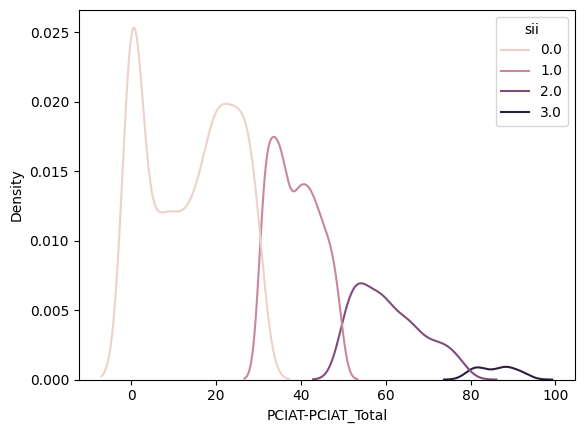

In [44]:
sns.kdeplot(train, x ='PCIAT-PCIAT_Total', hue = 'sii')


In [45]:
print(train[train['PCIAT-PCIAT_Total']<=30].sii.value_counts())
print(train[(train['PCIAT-PCIAT_Total']>30) 
    & (train['PCIAT-PCIAT_Total']<50)].sii.value_counts())
print(train[(train['PCIAT-PCIAT_Total']>=50) 
    & (train['PCIAT-PCIAT_Total']<80)].sii.value_counts())
print(train[train['PCIAT-PCIAT_Total']>=80].sii.value_counts())

sii
0.0    1594
Name: count, dtype: int64
sii
1.0    730
Name: count, dtype: int64
sii
2.0    378
Name: count, dtype: int64
sii
3.0    34
Name: count, dtype: int64


In [46]:
train.sii.value_counts()

sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64

In [47]:
PCIAT_cols.remove('PCIAT-PCIAT_Total')
train = train.drop(columns = PCIAT_cols)

Text(0.5, 1.0, 'Count of sii')

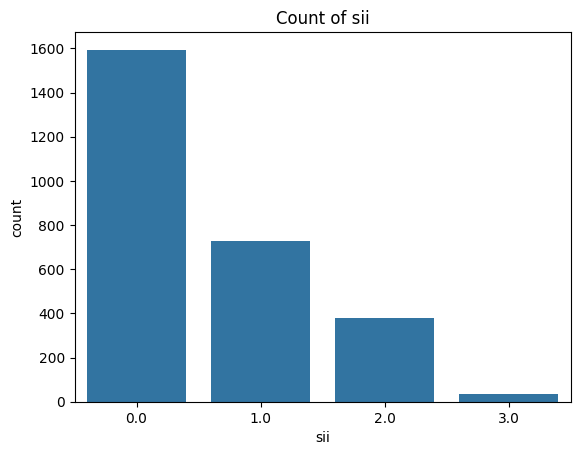

In [48]:
sns.countplot(train, x = 'sii').set_title('Count of sii')

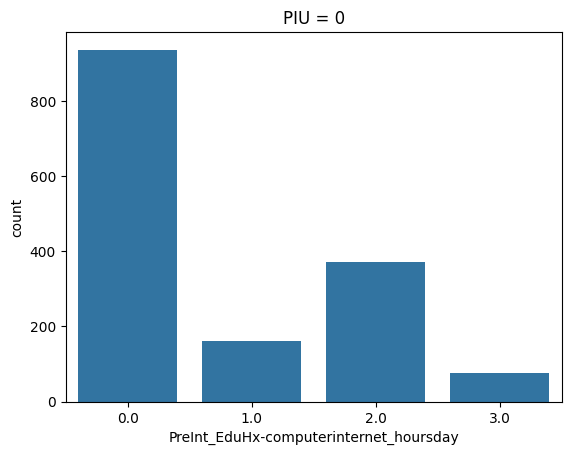

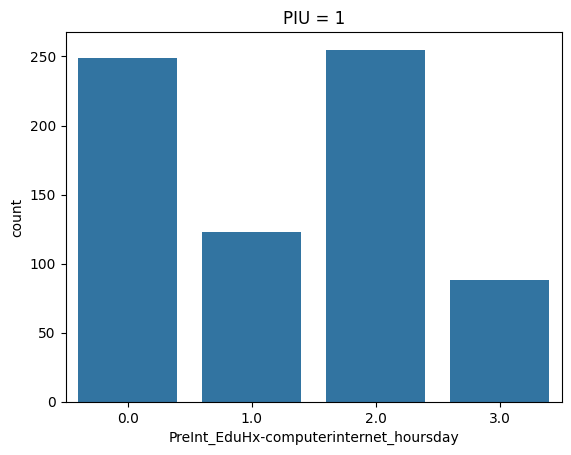

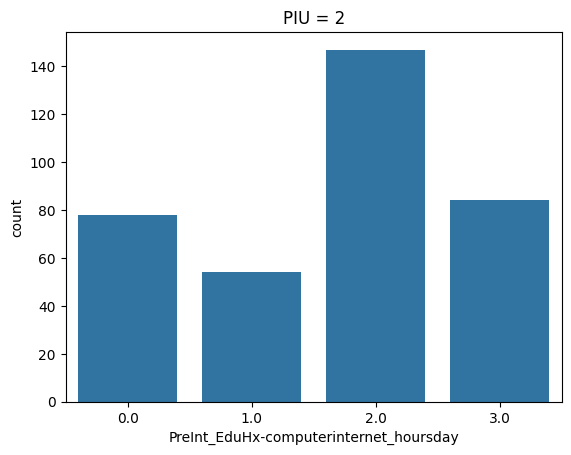

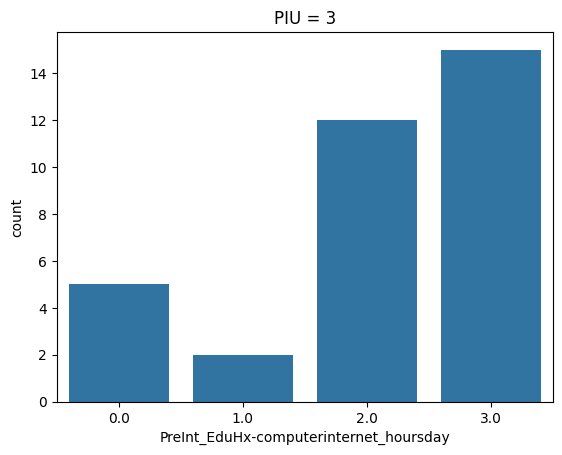

In [49]:
vals = ['PIU = 0', 'PIU = 1','PIU = 2', 'PIU = 3']

for i in range(4):
    plt.figure()
    plot = sns.countplot(x = train[train.sii==i]['PreInt_EduHx-computerinternet_hoursday'])
    plot.set_title(vals[i])

In [50]:
train = train.dropna(subset='sii')

In [54]:
corr = pd.DataFrame(train.corr(numeric_only=True)['PCIAT-PCIAT_Total'].sort_values(ascending = False))
corr.style.background_gradient(cmap='YlOrRd')


,PCIAT-PCIAT_Total
PCIAT-PCIAT_Total,1.000000
sii,0.899681
Physical-Height,0.420765
Basic_Demos-Age,0.409559
PreInt_EduHx-computerinternet_hoursday,0.374124
Physical-Weight,0.353048
Physical-Waist_Circumference,0.327013
FGC-FGC_CU,0.287494
BIA-BIA_BMI,0.248060
Physical-BMI,0.240858


In [55]:
selection = corr[(corr['PCIAT-PCIAT_Total']>.1) | (corr['PCIAT-PCIAT_Total']<-.1)]
selection = [val for val in selection.index]
selection.remove('PCIAT-PCIAT_Total')
selection.remove('sii')
selection.remove('Physical-BMI')
selection.remove('SDS-SDS_Total_Raw')

In [56]:
selection

['Physical-Height',
 'Basic_Demos-Age',
 'PreInt_EduHx-computerinternet_hoursday',
 'Physical-Weight',
 'Physical-Waist_Circumference',
 'FGC-FGC_CU',
 'BIA-BIA_BMI',
 'SDS-SDS_Total_T',
 'PAQ_A-Season',
 'FGC-FGC_PU',
 'BIA-BIA_Frame_num',
 'FGC-FGC_GSD',
 'Physical-Systolic_BP',
 'FGC-FGC_GSND',
 'FGC-FGC_TL',
 'PAQ_C-Season',
 'BIA-BIA_FFMI',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_SRL_Zone']

In [57]:
null = train.isna().sum().sort_values(ascending = False).head(46)
null = pd.DataFrame(null)
null = null.rename(columns= {0:'Missing'})
null.style.background_gradient(cmap='YlOrRd')

,Missing
PAQ_A-PAQ_A_Total,2373
Physical-Waist_Circumference,2253
Fitness_Endurance-Time_Sec,2008
Fitness_Endurance-Time_Mins,2008
Fitness_Endurance-Max_Stage,2005
FGC-FGC_GSD_Zone,1872
FGC-FGC_GSND_Zone,1872
FGC-FGC_GSD,1865
FGC-FGC_GSND,1864
PAQ_C-PAQ_C_Total,1296


In [58]:
half_missing = [val for val in train.columns[train.isnull().sum()>len(train)/2]]
half_missing

['Physical-Waist_Circumference',
 'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec',
 'FGC-FGC_GSND',
 'FGC-FGC_GSND_Zone',
 'FGC-FGC_GSD',
 'FGC-FGC_GSD_Zone',
 'PAQ_A-PAQ_A_Total']

In [59]:
selection = [i for i in selection if i not in half_missing]

In [60]:
describe = train[selection].describe().T
describe = describe[['min','max']].sort_index()
describe.style.background_gradient(cmap='YlOrRd')

,min,max
BIA-BIA_BMI,0.048267,48.375400
BIA-BIA_FFMI,7.864850,217.771000
BIA-BIA_Frame_num,1.000000,3.000000
Basic_Demos-Age,5.000000,22.000000
FGC-FGC_CU,0.000000,115.000000
FGC-FGC_PU,0.000000,51.000000
FGC-FGC_SRL_Zone,0.000000,1.000000
FGC-FGC_SRR_Zone,0.000000,1.000000
FGC-FGC_TL,0.000000,21.000000
PAQ_A-Season,0.000000,4.000000


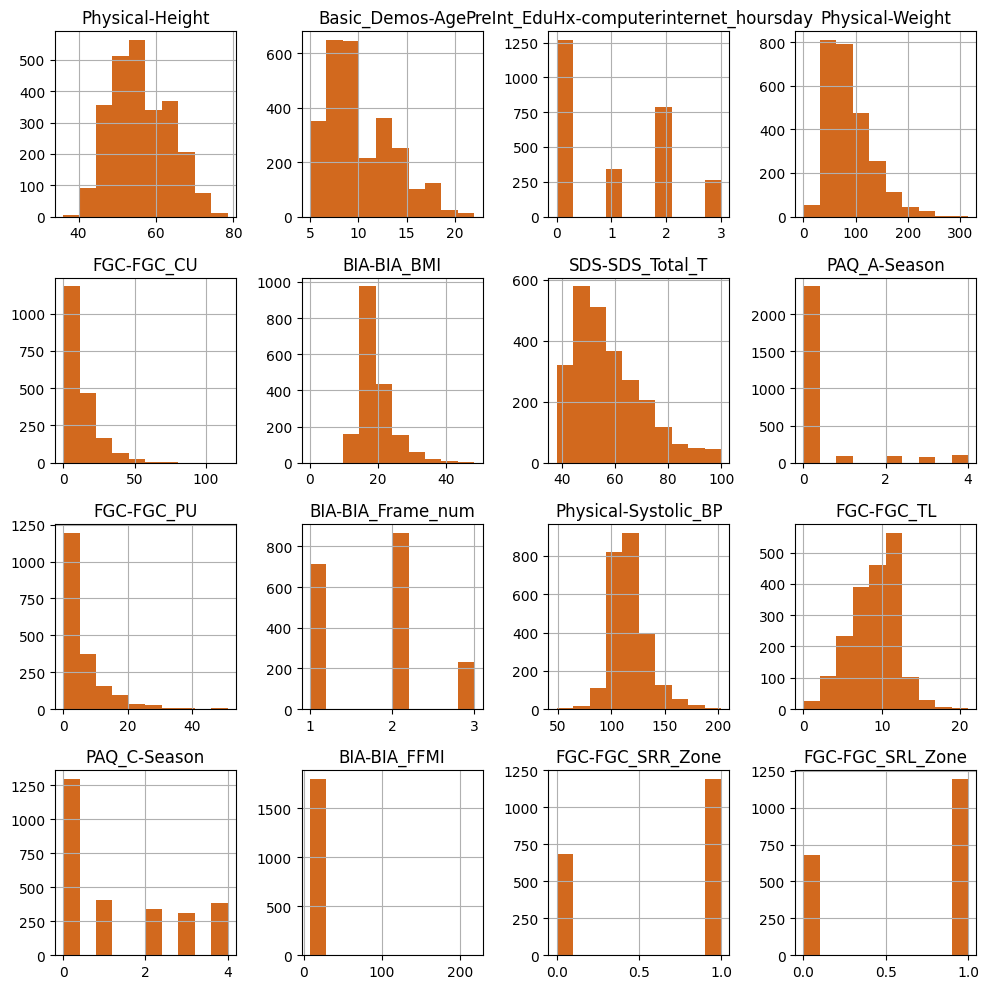

In [61]:
train[selection].hist(figsize=(10,10), grid = True, color = 'chocolate')
plt.tight_layout()

In [62]:
X = train[selection]
test = test[selection]
y = train['PCIAT-PCIAT_Total']

In [63]:
def convert(scores):
    scores = np.array(scores)
    bins = np.zeros_like(scores)
    bins[scores <= 30] = 0
    bins[(scores > 30) & (scores < 50)] = 1
    bins[(scores >= 50) & (scores < 80)] = 2
    bins[scores >= 80] = 3
    return bins

In [64]:
def convert2(scores):
    scores = np.array(scores)*1.252
    bins = np.zeros_like(scores)
    bins[scores <= 32] = 0
    bins[(scores > 32) & (scores < 50)] = 1
    bins[(scores >= 50) & (scores < 70)] = 2
    bins[scores >= 70] = 3
    return bins

In [65]:
def quadratic_kappa(y_true, y_pred):
    y_true_cat = convert(y_true)
    y_pred_cat = convert2(y_pred)
    return cohen_kappa_score(y_true_cat, y_pred_cat, weights='quadratic')

kappa_scorer = make_scorer(quadratic_kappa, greater_is_better=True)

In [66]:
params = {'max_depth': 3, 'n_estimators': 59, 'learning_rate': 0.073, 'subsample': 0.59, 'colsample_bytree': 0.9}

In [67]:
skf = StratifiedKFold(n_splits=10)
model = xgb.XGBRegressor(**params)

In [68]:
scores = cross_val_score(model, X, y, cv=skf, scoring=kappa_scorer)
print("QWK Scores:", scores)
print("Mean QWK Score:", np.mean(scores))

c:\Users\anime\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



QWK Scores: [0.37407398 0.49184223 0.4901377  0.46447318 0.52797113 0.45593578
 0.4527134  0.38116138 0.43829076 0.41645885]
Mean QWK Score: 0.44930583940699265


In [69]:
model.fit(X,y)
feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

Basic_Demos-Age                           0.253897
PreInt_EduHx-computerinternet_hoursday    0.119438
Physical-Height                           0.094246
SDS-SDS_Total_T                           0.073609
PAQ_A-Season                              0.061770
FGC-FGC_CU                                0.054060
Physical-Weight                           0.052100
FGC-FGC_PU                                0.051688
PAQ_C-Season                              0.044382
Physical-Systolic_BP                      0.034121
BIA-BIA_BMI                               0.033213
BIA-BIA_Frame_num                         0.032994
FGC-FGC_SRL_Zone                          0.032626
FGC-FGC_TL                                0.031380
BIA-BIA_FFMI                              0.030476
FGC-FGC_SRR_Zone                          0.000000
dtype: float32

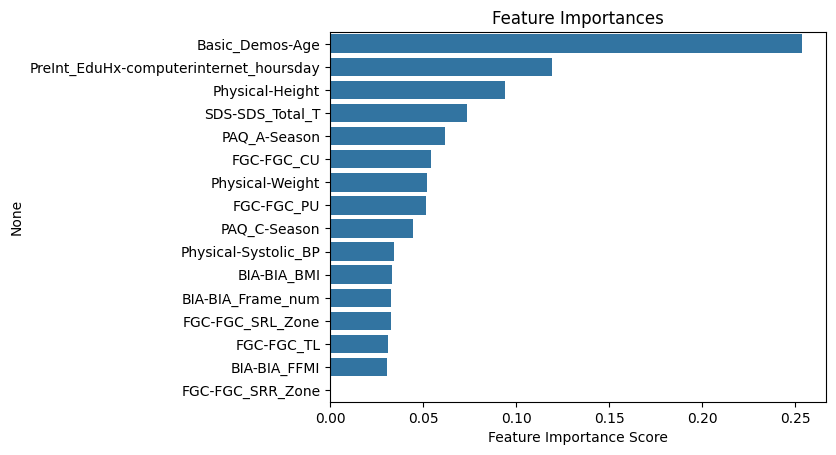

In [70]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.title("Feature Importances")
plt.show()

In [71]:
model.fit(X,y)
preds = model.predict(test)
preds = convert2(preds) # convert raw scores to sii categories if using regressor
preds = pd.Series(preds)
preds.index = test.index
preds.to_csv('submission.csv')
preds

0     1.0
1     0.0
2     1.0
3     0.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    0.0
16    0.0
17    1.0
18    1.0
19    1.0
dtype: float32